In [2]:
import os
import hail as hl
import pandas as pd
import numpy as np
from dask.distributed import Client, progress
import dask.array as da
from gwas_analysis.dask import io, codecs
from pysnptools.snpreader import Bed
%run {os.environ['NB_DIR']}/nb.py
%run $BENCHMARK_METHOD_DIR/common.py
#plink_file = osp.expanduser('~/data/gwas/tutorial/2_PS_GWAS/ALL.2of4intersection.20100804.genotypes')
plink_file = osp.expanduser('~/data/gwas/tutorial/1_QC_GWAS/HapMap_3_r3_1')

In [6]:
%run {os.environ['NB_DIR']}/nb.py

In [10]:
%run $TUTORIAL_DIR/reference_genome.py
hl.ReferenceGenome(**hapmap3_hg18_rg())

ReferenceGenome(name=hapmap3_hg18, contigs=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '25'], lengths={'1': 247249719, '2': 242951149, '3': 199501827, '4': 191273063, '5': 180857866, '6': 170899992, '7': 158821424, '8': 146274826, '9': 140273252, '10': 135374737, '11': 134452384, '12': 132349534, '13': 114142980, '14': 106368585, '15': 100338915, '16': 88827254, '17': 78774742, '18': 76117153, '19': 63811651, '20': 62435964, '21': 46944323, '22': 49691432, '23': 154913754, '25': 154913754}, x_contigs=['23'], y_contigs=[], mt_contigs=[], par=[])

In [13]:
mt = hl.import_plink(
    *plink_files(osp.dirname(plink_file), osp.basename(plink_file)),
    skip_invalid_loci=False,
    reference_genome='hapmap3_hg18'
)

2020-02-20 21:14:19 Hail: INFO: Found 165 samples in fam file.
2020-02-20 21:14:19 Hail: INFO: Found 1457897 variants in bim file.


In [ ]:
hl.export_plink()

In [14]:
%%time
ld = hl.ld_matrix(mt.GT.n_alt_alleles(), mt.locus, radius=3e9)

2020-02-20 21:14:32 Hail: INFO: Coerced sorted dataset
2020-02-20 21:18:34 Hail: INFO: Wrote all 356 blocks of 1457897 x 165 matrix with block size 4096.
2020-02-20 21:18:39 Hail: INFO: Coerced sorted dataset


In [2]:
from numcodecs.registry import register_codec
register_codec(codecs.PackGeneticBits)
client = Client(processes=True, threads_per_worker=1, n_workers=8, memory_limit='16GB')
client.register_worker_plugin(codecs.CodecPlugin())
client

Client Scheduler: tcp://127.0.0.1:36715 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 128.00 GB


In [3]:
gtr = da.from_array(io.BedArray(Bed(plink_file, count_A1=True)), chunks=(50000, 629), lock=False)
gtr

dask.array<array, shape=(1457897, 165), dtype=uint8, chunksize=(50000, 165), chunktype=numpy.ndarray>

In [5]:
gtr.to_zarr('/tmp/gt.zarr', overwrite=True)

In [3]:
gt = da.from_zarr('/tmp/gt.zarr')
gt

dask.array<from-zarr, shape=(1457897, 165), dtype=uint8, chunksize=(50000, 165), chunktype=numpy.ndarray>

In [4]:
gt.sum(axis=1).sum().compute()

337027557

In [5]:
prj = da.random.normal(size=(gt.shape[1], 32), chunks=gt.chunksize)
prj

dask.array<normal, shape=(165, 32), dtype=float64, chunksize=(165, 32), chunktype=numpy.ndarray>

In [6]:
xs = gt @ prj
xs = da.signbit(xs)
xs

dask.array<signbit, shape=(1457897, 32), dtype=bool, chunksize=(50000, 32), chunktype=numpy.ndarray>

In [26]:
# def packbits(v, axis=None):
#     if v.shape[0] > 1:
#         print(axis)
#         print(v.shape)
#         print(np.packbits(v))
#         raise ValueError(str(v.shape))
#     return np.packbits(v)
        
# xsp = da.coarsen(packbits, xs, axes={0:1, 1: 8})
# xsp

In [7]:
xb = da.apply_along_axis(
    lambda a: str(int(''.join(a), 2)), 
    axis=1, arr=da.where(xs, '1', '0'))
xb

dask.array<lambda-along-axis, shape=(1457897,), dtype=<U1, chunksize=(50000,), chunktype=numpy.ndarray>

In [8]:
%%time
s = pd.Series(xb.compute())
s

CPU times: user 801 ms, sys: 141 ms, total: 941 ms
Wall time: 3.94 s


0          2095529
1          1046953
2          2095529
3           911801
4          5379137
            ...   
1457892    1042873
1457893    1042873
1457894    2025913
1457895    2095529
1457896    5463064
Length: 1457897, dtype: object

In [34]:
s.value_counts()

2095529       150841
1046953        22615
538966441      16224
2091433        15842
537917865      15462
               ...  
2774737            1
1964536            1
209322             1
1075837435         1
2873087            1
Length: 21218, dtype: int64

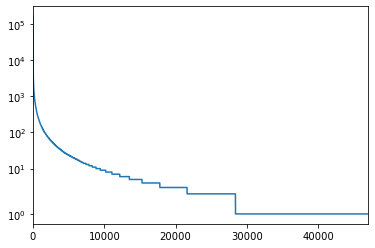

In [13]:
ax = s.value_counts().reset_index(drop=True).plot()
ax.set_yscale('symlog')

In [9]:
import dask.dataframe as dd

In [12]:
df = dd.from_array(xb, columns=['b']).reset_index()
df

,index,b
npartitions=30,,
,int64,object
,...,...
...,...,...
,...,...
,...,...


In [19]:
dfv = df.groupby('b').first()
dfv

,index
npartitions=1,
,int64
,...


In [22]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [23]:
%%time 
dfvr = dfv.compute()

CPU times: user 851 ms, sys: 44.3 ms, total: 895 ms
Wall time: 5.47 s


In [25]:
dfvr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21218 entries, 1008682 to 944637
Data columns (total 1 columns):
index    21218 non-null int64
dtypes: int64(1)
memory usage: 331.5+ KB


In [33]:
s.value_counts()

2095529       150841
1046953        22615
538966441      16224
2091433        15842
537917865      15462
               ...  
2774737            1
1964536            1
209322             1
1075837435         1
2873087            1
Length: 21218, dtype: int64

## Evaluation

In [3]:
hl.init()

Running on Apache Spark version 2.4.4
SparkUI available at http://2e4e0c6972f9:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.32-a5876a0a2853
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/benchmark/method/ld_prune/hail-20200220-2109-0.2.32-a5876a0a2853.log


In [17]:
ld.shape

(1457897, 1457897)